ELEC6910X Advanced Topics in AI and Healthcare

# Assignment 1

***Holy Lovenia - 20814158***

------

In [2]:
from collections import OrderedDict
from PIL import Image
from pytorch3dunet.unet3d import losses
from torch import nn
from torch.autograd import Variable
from torch.nn import init
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomVerticalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)
from transformers import AutoConfig, AutoFeatureExtractor, AutoModelForImageClassification, TrainingArguments, Trainer, EarlyStoppingCallback
from tqdm import tqdm

import datasets
import h5py
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import surface_distance.metrics as sf
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchio as tio
import torchmetrics
import torchvision

In [3]:
RANDOM_SEED = 42

def set_all_seeds(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True

set_all_seeds(RANDOM_SEED)

## Problem 2: Skin Lesion Classification

In [4]:
NUM_CLASSES = 7

In [5]:
model_name_or_path = "microsoft/resnet-152"

### Data loading

#### Function declaration

Loading function for `problem2_datas` dataset.

In [6]:
def problem2_load_dataset(manifest_path, img_dir_path, img_column_name="image_train", label_column_name="label_train", return_df=False):
    manifest_df = pd.read_csv(manifest_path)
    manifest_df[img_column_name] = img_dir_path + manifest_df[img_column_name].astype(str)
    manifest_df = manifest_df.rename(columns={img_column_name: "image", label_column_name: "label"})
    dataset = datasets.Dataset.from_pandas(manifest_df)
    dataset = dataset.cast_column("image", datasets.Image(decode=True))
    dataset = dataset.class_encode_column("label")
    if return_df:
        return dataset, manifest_df
    else:
        return dataset

Loading function for `HAM10000` dataset.

You can download the dataset from [Kaggle](https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000) before starting the experiment.

Since the `problem2_datas` and `HAM10000` datasets are both skin lesion classification datasets that have the same classes, let's convert the label configuration in `HAM10000` to that of `problem2_datas`. Clinical labels are obtained from the `HAM10000` dataset paper [here](https://arxiv.org/abs/1902.03368).

|`problem2_datas` Label ID|`HAM10000` Label ID|Clinical Label|
|-------|-------|-------|
|0|mel|Melanoma|
|1|nv|Nevi|
|2|bcc|Basal cell carcinoma|
|3|akiec|Actinic keratoses|
|4|bkl|Benign keratosis|
|5|df|Dermafibratoma|
|6|vasc|Vascular lesion|

In [7]:
def ham10000_load_dataset(manifest_path, img_dir_paths, img_column_name="image_id", label_column_name="dx", return_df=False):
    manifest_df = pd.read_csv(manifest_path)
    for i in range(len(manifest_df)):
        for img_dir_path in img_dir_paths:
            img_path = os.path.join(img_dir_path, f"{manifest_df[img_column_name][i]}.jpg")
            if os.path.isfile(img_path):
                manifest_df[img_column_name][i] = img_path
    manifest_df = manifest_df.drop(manifest_df[~manifest_df[img_column_name].str.contains(".jpg")].index)
    manifest_df = manifest_df.rename(columns={img_column_name: "image", label_column_name: "label"})
    manifest_df = manifest_df.replace({
        "mel": 0,
        "nv": 1,
        "bcc": 2,
        "akiec": 3,
        "bkl": 4,
        "df": 5,
        "vasc": 6,
    })
    dataset = datasets.Dataset.from_pandas(manifest_df)
    dataset = dataset.cast_column("image", datasets.Image(decode=True))
    dataset = dataset.class_encode_column("label")
    if return_df:
        return dataset, manifest_df
    else:
        return dataset

#### Function utilization

Load the `problem2_datas` dataset.

I use this data as the sole training dataset in Experiment 1 and as a fine-tuning dataset in Experiment 2. Since the assignment asks for a "test loss curve", then the test split is used for validation.

In [8]:
raw_datasets = datasets.DatasetDict()
raw_datasets["train"], train_df = problem2_load_dataset(
    "./data/problem2_datas/annotation/train.csv", "./data/problem2_datas/images/", return_df=True)
raw_datasets["valid"] = problem2_load_dataset(
    "./data/problem2_datas/annotation/test.csv", "./data/problem2_datas/images/")
raw_datasets

Stringifying the column:   0%|          | 0/1 [00:00<?, ?ba/s]

Casting to class labels:   0%|          | 0/1 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

Stringifying the column:   0%|          | 0/1 [00:00<?, ?ba/s]

Casting to class labels:   0%|          | 0/1 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 305
    })
    valid: Dataset({
        features: ['image', 'label'],
        num_rows: 99
    })
})

Display the label statistics of the `problem2_datas` dataset.

In [9]:
label_stats = train_df["label"].value_counts()
label_stats

1    206
0     34
4     33
2     15
3     10
6      4
5      3
Name: label, dtype: int64

Wow, so imbalanced. Let's get the class weights. They can be used to adjust the cross-entropy loss later.

In [10]:
num_train_labels = sum(label_stats)
train_class_weights = []
for i in range(NUM_CLASSES):
    train_class_weights.append(float(round(train_df["label"].value_counts()[i] / num_train_labels, 2)))
train_class_weights

[0.11, 0.68, 0.05, 0.03, 0.11, 0.01, 0.01]

What do the data look like? Let's display a data sample of each class in the `problem2_datas`.

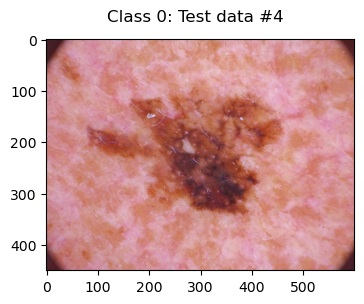

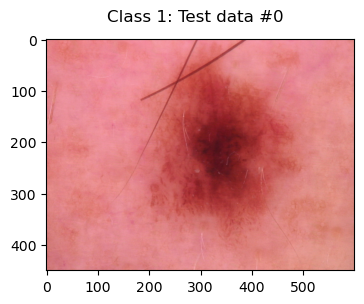

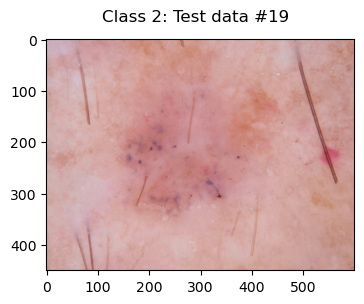

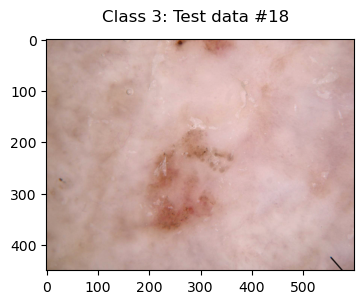

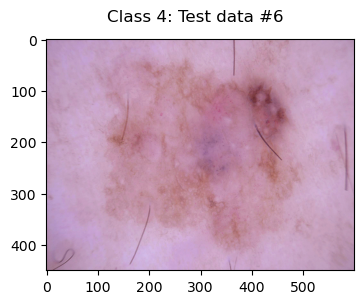

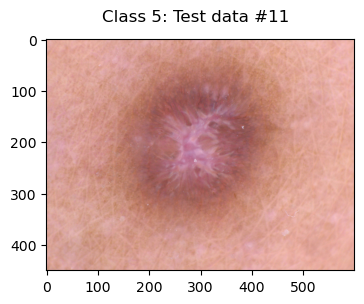

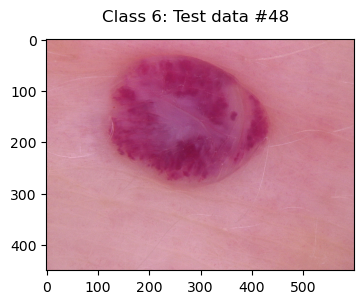

In [11]:
for class_id in range(NUM_CLASSES):
    # Get the index of the first sample from `class_id`
    index = train_df.index[train_df["label"] == class_id][0]
    plt.figure(figsize=(4, 3))
    plt.suptitle(f'Class {class_id}: Test data #{index}', fontsize=12)
    plt.imshow(raw_datasets["train"][int(index)]["image"])

Load the `HAM10000` dataset.

I use this data as a pre-training dataset in Experiment 2.

In [12]:
pretrain_datasets = datasets.DatasetDict()
pretrain_train_val_dataset = ham10000_load_dataset(
    "./data/HAM10000/HAM10000_metadata.csv",
    [
        "./data/HAM10000/ham10000_images_part_1",
        "./data/HAM10000/HAM10000_images_part_1",
        "./data/HAM10000/ham10000_images_part_2",
        "./data/HAM10000/HAM10000_images_part_2"
    ]).train_test_split(test_size=0.2)
pretrain_datasets["train"] = pretrain_train_val_dataset["train"]
pretrain_datasets["valid"] = pretrain_train_val_dataset["test"]
pretrain_datasets

/tmp/ipykernel_27236/1366491957.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  manifest_df[img_column_name][i] = img_path


Stringifying the column:   0%|          | 0/11 [00:00<?, ?ba/s]

Casting to class labels:   0%|          | 0/11 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/2 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['lesion_id', 'image', 'label', 'dx_type', 'age', 'sex', 'localization'],
        num_rows: 1600
    })
    valid: Dataset({
        features: ['lesion_id', 'image', 'label', 'dx_type', 'age', 'sex', 'localization'],
        num_rows: 400
    })
})

### Preprocessing

Initialize the feature extractor I want to use.

In [13]:
feature_extractor = AutoFeatureExtractor.from_pretrained(model_name_or_path)

#### Function declarations

Augmentation and preprocessing functions.

In [14]:
normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
train_transforms = Compose(
        [
            Resize(feature_extractor.size),
            CenterCrop(feature_extractor.size),
            RandomHorizontalFlip(),
            RandomVerticalFlip(),
            ToTensor(),
            normalize,
        ]
    )

eval_transforms = Compose(
        [
            Resize(feature_extractor.size),
            CenterCrop(feature_extractor.size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_eval(example_batch):
    """Apply eval_transforms across a batch."""
    example_batch["pixel_values"] = [
        eval_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

Data collator.

This will be useful for batched data processing later.

In [15]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

#### Function utilization

Don't forget to preprocess both the `problem2_datas` dataset and the `HAM10000` dataset.

In [16]:
proc_datasets = raw_datasets
proc_datasets["train"].set_transform(preprocess_train)
proc_datasets["valid"].set_transform(preprocess_eval)

In [17]:
proc_pretrain_datasets = pretrain_datasets
proc_pretrain_datasets["train"].set_transform(preprocess_train)
proc_pretrain_datasets["valid"].set_transform(preprocess_eval)

### Training and evaluation

#### Function declarations

Modified Trainer.

Use the pre-computed `train_class_weights` to adjust the cross entropy loss.

In [18]:
class SkinLesionTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels").to("cuda")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits").to("cuda")
        # compute weighted cross entropy loss
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor(train_class_weights + [0 for i in range(993)])).to("cuda")
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

Accuracy evaluation metric.

In [19]:
metric = datasets.load_metric("accuracy")

/tmp/ipykernel_27236/3770023701.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = datasets.load_metric("accuracy")


In [20]:
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

Evaluation.

In [21]:
def evaluation(trainer, datasets=[], eval_names=[]):
    for dset, name in zip(datasets, eval_names):
        metrics = trainer.evaluate(dset)
        trainer.log_metrics(name, metrics)
        trainer.save_metrics(name, metrics)

Pre-training loop.

In [22]:
def pretraining(
    model,
    output_dir=f"save/problem2/pretrain__{model_name_or_path}__1e-3__submitted",
    train_dataset=proc_pretrain_datasets["train"],
    eval_dataset=proc_pretrain_datasets["valid"],
    trainer_class=SkinLesionTrainer):
    
    args = TrainingArguments(
        output_dir,
        remove_unused_columns=False,
        evaluation_strategy = "epoch",
        save_strategy = "epoch",
        learning_rate=1e-3,
        per_device_train_batch_size=32,
        gradient_accumulation_steps=4,
        per_device_eval_batch_size=32,
        num_train_epochs=200,
        warmup_ratio=0.1,
        logging_steps=10,
        load_best_model_at_end=True,
        metric_for_best_model="eval_accuracy",
        gradient_checkpointing=True,
        save_total_limit=1,
        seed=RANDOM_SEED,
        data_seed=RANDOM_SEED,
        dataloader_num_workers=4,
        lr_scheduler_type="cosine",
        fp16=True,
        report_to="wandb",
        run_name=output_dir,
    )
    
    trainer = trainer_class(
        model,
        args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        tokenizer=feature_extractor,
        compute_metrics=compute_metrics,
        data_collator=collate_fn,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=10)],
    )
    
    train_results = trainer.train()
    trainer.save_model()
    
    return trainer

Training loop.

In [23]:
def training(
    model,
    output_dir=f"save/problem2/{model_name_or_path}__1e-3__submitted",
    train_dataset=proc_datasets["train"],
    eval_dataset=proc_datasets["valid"],
    trainer_class=SkinLesionTrainer,
):
    args = TrainingArguments(
        output_dir,
        remove_unused_columns=False,
        evaluation_strategy = "epoch",
        save_strategy = "epoch",
        learning_rate=1e-3,
        per_device_train_batch_size=32,
        gradient_accumulation_steps=4,
        per_device_eval_batch_size=32,
        num_train_epochs=200,
        warmup_ratio=0.1,
        logging_steps=10,
        load_best_model_at_end=True,
        metric_for_best_model="eval_accuracy",
        gradient_checkpointing=True,
        save_total_limit=1,
        seed=RANDOM_SEED,
        data_seed=RANDOM_SEED,
        dataloader_num_workers=4,
        lr_scheduler_type="cosine",
        fp16=True,
        report_to="wandb",
        run_name=output_dir, 
    )
    
    trainer = trainer_class(
        model,
        args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        tokenizer=feature_extractor,
        compute_metrics=compute_metrics,
        data_collator=collate_fn,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=20)],
    )
    
    train_results = trainer.train()
    trainer.save_model()
    
    return trainer

#### Function utilization

In [23]:
setting1_model = AutoModelForImageClassification.from_pretrained(model_name_or_path)

#### Setting 1: Without pre-training

In [24]:
trainer = training(
    setting1_model,
    output_dir=f"save/problem2/{model_name_or_path}__1e-3__submitted",
    train_dataset=proc_datasets["train"],
    eval_dataset=proc_datasets["valid"])

Using cuda_amp half precision backend
/home/holy/anaconda3/envs/health/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 305
  Num Epochs = 200
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 400
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: Currently logged in as: holylovenia. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
0,No log,7.047606,0.000000
1,No log,7.053577,0.000000
2,No log,7.399084,0.000000
3,No log,7.270785,0.000000
4,9.018300,6.764757,0.000000
5,9.018300,5.824580,0.010101
6,9.018300,5.067624,0.090909
7,9.018300,3.895259,0.333333
8,9.018300,2.491891,0.535354
9,6.515600,1.651899,0.616162


***** Running Evaluation *****
  Num examples = 99
  Batch size = 32
Saving model checkpoint to save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-2
Configuration saved in save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-2/config.json
Model weights saved in save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-2/pytorch_model.bin
Feature extractor saved in save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-2/preprocessor_config.json
Deleting older checkpoint [save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-108] due to args.save_total_limit
Deleting older checkpoint [save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-148] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 99
  Batch size = 32
Saving model checkpoint to save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-4
Configuration saved in save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-4/config.json
Model w

Configuration saved in save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-28/config.json
Model weights saved in save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-28/pytorch_model.bin
Feature extractor saved in save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-28/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 99
  Batch size = 32
Saving model checkpoint to save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-30
Configuration saved in save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-30/config.json
Model weights saved in save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-30/pytorch_model.bin
Feature extractor saved in save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-30/preprocessor_config.json
Deleting older checkpoint [save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-28] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 99
  Batch size

***** Running Evaluation *****
  Num examples = 99
  Batch size = 32
Saving model checkpoint to save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-56
Configuration saved in save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-56/config.json
Model weights saved in save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-56/pytorch_model.bin
Feature extractor saved in save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-56/preprocessor_config.json
Deleting older checkpoint [save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-46] due to args.save_total_limit
Deleting older checkpoint [save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-54] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 99
  Batch size = 32
Saving model checkpoint to save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-58
Configuration saved in save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-58/config.json
Mod

Model weights saved in save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-82/pytorch_model.bin
Feature extractor saved in save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-82/preprocessor_config.json
Deleting older checkpoint [save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-80] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 99
  Batch size = 32
Saving model checkpoint to save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-84
Configuration saved in save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-84/config.json
Model weights saved in save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-84/pytorch_model.bin
Feature extractor saved in save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-84/preprocessor_config.json
Deleting older checkpoint [save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-82] due to args.save_total_limit
***** Running Evaluation *****
  Num exam

Feature extractor saved in save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-108/preprocessor_config.json
Deleting older checkpoint [save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-106] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 99
  Batch size = 32
Saving model checkpoint to save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-110
Configuration saved in save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-110/config.json
Model weights saved in save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-110/pytorch_model.bin
Feature extractor saved in save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-110/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 99
  Batch size = 32
Saving model checkpoint to save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-112
Configuration saved in save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-112/config.json


Saving model checkpoint to save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-136
Configuration saved in save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-136/config.json
Model weights saved in save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-136/pytorch_model.bin
Feature extractor saved in save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-136/preprocessor_config.json
Deleting older checkpoint [save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-134] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 99
  Batch size = 32
Saving model checkpoint to save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-138
Configuration saved in save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-138/config.json
Model weights saved in save/problem2/microsoft/resnet-152__1e-3__submitted/checkpoint-138/pytorch_model.bin
Feature extractor saved in save/problem2/microsoft/resnet-152__1e-3__submitted/c

In [25]:
evaluation(
    trainer,
    datasets=[proc_datasets["valid"]],
    eval_names=["problem2_datas__valid"]
)

***** Running Evaluation *****
  Num examples = 99
  Batch size = 32


***** problem2_datas__valid metrics *****
  epoch                   =       73.8
  eval_accuracy           =     0.8283
  eval_loss               =     0.2194
  eval_runtime            = 0:00:01.64
  eval_samples_per_second =     60.227
  eval_steps_per_second   =      2.433


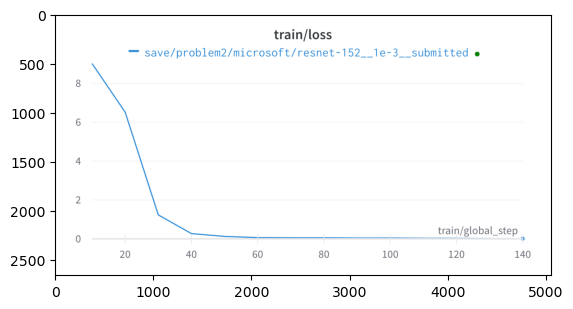

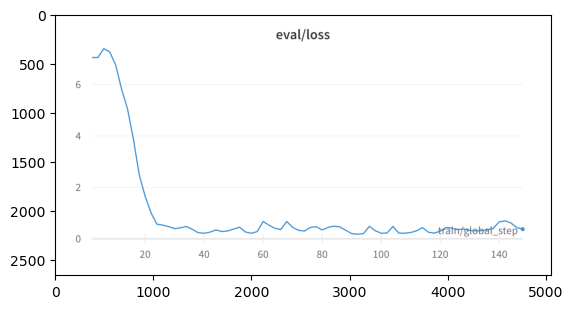

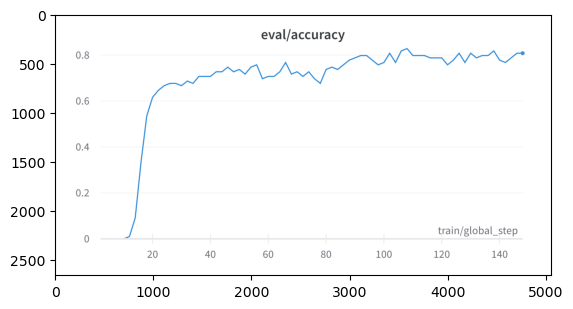

In [35]:
plt.figure()
img = mpimg.imread("./log/problem2/setting1/setting1_train_loss.png")
plt.imshow(img)

plt.figure()
img = mpimg.imread("./log/problem2/setting1/setting1_valid_loss.png")
plt.imshow(img)

plt.figure()
img = mpimg.imread("./log/problem2/setting1/setting1_valid_acc.png")
plt.imshow(img)

#### Setting 2: With pre-training

Pre-training.

In [36]:
setting2_pretraining_model = AutoModelForImageClassification.from_pretrained(model_name_or_path)

loading configuration file config.json from cache at /home/holy/.cache/huggingface/hub/models--microsoft--resnet-152/snapshots/26958355fd2ec78b3e07b7094b8778c242907844/config.json
Model config ResNetConfig {
  "_name_or_path": "microsoft/resnet-152",
  "architectures": [
    "ResNetForImageClassification"
  ],
  "depths": [
    3,
    8,
    36,
    3
  ],
  "downsample_in_first_stage": false,
  "embedding_size": 64,
  "hidden_act": "relu",
  "hidden_sizes": [
    256,
    512,
    1024,
    2048
  ],
  "id2label": {
    "0": "tench, Tinca tinca",
    "1": "goldfish, Carassius auratus",
    "2": "great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias",
    "3": "tiger shark, Galeocerdo cuvieri",
    "4": "hammerhead, hammerhead shark",
    "5": "electric ray, crampfish, numbfish, torpedo",
    "6": "stingray",
    "7": "cock",
    "8": "hen",
    "9": "ostrich, Struthio camelus",
    "10": "brambling, Fringilla montifringilla",
    "11": "goldfinch, Carduel

loading weights file pytorch_model.bin from cache at /home/holy/.cache/huggingface/hub/models--microsoft--resnet-152/snapshots/26958355fd2ec78b3e07b7094b8778c242907844/pytorch_model.bin
All model checkpoint weights were used when initializing ResNetForImageClassification.

All the weights of ResNetForImageClassification were initialized from the model checkpoint at microsoft/resnet-152.
If your task is similar to the task the model of the checkpoint was trained on, you can already use ResNetForImageClassification for predictions without further training.


In [37]:
pretrainer = pretraining(
    setting2_pretraining_model,
    output_dir=f"save/problem2/pretrain__{model_name_or_path}__1e-3__submitted",
    train_dataset=proc_pretrain_datasets["train"],
    eval_dataset=proc_pretrain_datasets["valid"])

PyTorch: setting up devices
Using cuda_amp half precision backend
/home/holy/anaconda3/envs/health/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1600
  Num Epochs = 200
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 2400
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss,Accuracy
0,7.536400,7.284433,0.000000
1,7.589800,6.353826,0.005000
2,6.775900,4.979838,0.210000
3,5.656800,2.077876,0.587500
4,1.677900,1.081237,0.715000
5,0.899600,0.609056,0.732500
6,0.543500,0.480014,0.737500
7,0.342800,0.427933,0.805000
8,0.336500,0.398646,0.787500
9,0.265300,0.475188,0.805000


***** Running Evaluation *****
  Num examples = 400
  Batch size = 32
Saving model checkpoint to save/problem2/pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-12
Configuration saved in save/problem2/pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-12/config.json
Model weights saved in save/problem2/pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-12/pytorch_model.bin
Feature extractor saved in save/problem2/pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-12/preprocessor_config.json
Deleting older checkpoint [save/problem2/pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-72] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 400
  Batch size = 32
Saving model checkpoint to save/problem2/pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-24
Configuration saved in save/problem2/pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-24/config.json
Model weights saved in save/problem2/pretrain__microso

Feature extractor saved in save/problem2/pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-156/preprocessor_config.json
Deleting older checkpoint [save/problem2/pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-144] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 400
  Batch size = 32
Saving model checkpoint to save/problem2/pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-168
Configuration saved in save/problem2/pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-168/config.json
Model weights saved in save/problem2/pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-168/pytorch_model.bin
Feature extractor saved in save/problem2/pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-168/preprocessor_config.json
Deleting older checkpoint [save/problem2/pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-156] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 400
  Batch size = 32


***** Running Evaluation *****
  Num examples = 400
  Batch size = 32
Saving model checkpoint to save/problem2/pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-312
Configuration saved in save/problem2/pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-312/config.json
Model weights saved in save/problem2/pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-312/pytorch_model.bin
Feature extractor saved in save/problem2/pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-312/preprocessor_config.json
Deleting older checkpoint [save/problem2/pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-300] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 400
  Batch size = 32
Saving model checkpoint to save/problem2/pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-324
Configuration saved in save/problem2/pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-324/config.json
Model weights saved in save/problem2/pretrain__

Model weights saved in save/problem2/pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-456/pytorch_model.bin
Feature extractor saved in save/problem2/pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-456/preprocessor_config.json
Deleting older checkpoint [save/problem2/pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-420] due to args.save_total_limit
Deleting older checkpoint [save/problem2/pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-444] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 400
  Batch size = 32
Saving model checkpoint to save/problem2/pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-468
Configuration saved in save/problem2/pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-468/config.json
Model weights saved in save/problem2/pretrain__microsoft/resnet-152__1e-3__submitted/checkpoint-468/pytorch_model.bin
Feature extractor saved in save/problem2/pretrain__microsoft/resnet-152__1e-3__su

In [38]:
evaluation(
    pretrainer,
    datasets=[proc_pretrain_datasets["valid"], proc_datasets["valid"]],
    eval_names=["ham10000__valid", "problem2_datas__valid"]
)

***** Running Evaluation *****
  Num examples = 400
  Batch size = 32


***** Running Evaluation *****
  Num examples = 99
  Batch size = 32


***** ham10000__valid metrics *****
  epoch                   =      47.96
  eval_accuracy           =     0.8775
  eval_loss               =     0.4481
  eval_runtime            = 0:00:02.86
  eval_samples_per_second =    139.503
  eval_steps_per_second   =      4.534
***** problem2_datas__valid metrics *****
  epoch                   =      47.96
  eval_accuracy           =     0.1818
  eval_loss               =     8.9857
  eval_runtime            = 0:00:01.48
  eval_samples_per_second =     66.747
  eval_steps_per_second   =      2.697


Fine-tuning.

In [24]:
setting2_finetuning_model = AutoModelForImageClassification.from_pretrained(
    f"save/problem2/pretrain__{model_name_or_path}__1e-3__submitted")

In [25]:
trainer = training(
    setting2_finetuning_model,
    output_dir=f"save/problem2/pretrained__1e-3|{model_name_or_path}__1e-3__submitted",
    train_dataset=proc_datasets["train"],
    eval_dataset=proc_datasets["valid"])

Using cuda_amp half precision backend
/home/holy/anaconda3/envs/health/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 305
  Num Epochs = 200
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 400
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: Currently logged in as: holylovenia. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
0,No log,9.743649,0.181818
1,No log,9.509656,0.191919
2,No log,8.557146,0.181818
3,No log,7.036314,0.181818
4,10.672100,5.320508,0.181818
5,10.672100,3.856836,0.212121
6,10.672100,3.416615,0.272727
7,10.672100,2.804009,0.383838
8,10.672100,1.785927,0.535354
9,4.037200,0.968431,0.616162


***** Running Evaluation *****
  Num examples = 99
  Batch size = 32
Saving model checkpoint to save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-2
Configuration saved in save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-2/config.json
Model weights saved in save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-2/pytorch_model.bin
Feature extractor saved in save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-2/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 99
  Batch size = 32
Saving model checkpoint to save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-4
Configuration saved in save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-4/config.json
Model weights saved in save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-4/pytorch_model.bin
Feature extractor saved in sav

  Num examples = 99
  Batch size = 32
Saving model checkpoint to save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-26
Configuration saved in save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-26/config.json
Model weights saved in save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-26/pytorch_model.bin
Feature extractor saved in save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-26/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 99
  Batch size = 32
Saving model checkpoint to save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-28
Configuration saved in save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-28/config.json
Model weights saved in save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-28/pytorch_model.bin
Feature extractor saved in save/problem2/pretrained__1

***** Running Evaluation *****
  Num examples = 99
  Batch size = 32
Saving model checkpoint to save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-50
Configuration saved in save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-50/config.json
Model weights saved in save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-50/pytorch_model.bin
Feature extractor saved in save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-50/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 99
  Batch size = 32
Saving model checkpoint to save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-52
Configuration saved in save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-52/config.json
Model weights saved in save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-52/pytorch_model.bin
Feature extractor saved

***** Running Evaluation *****
  Num examples = 99
  Batch size = 32
Saving model checkpoint to save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-74
Configuration saved in save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-74/config.json
Model weights saved in save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-74/pytorch_model.bin
Feature extractor saved in save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-74/preprocessor_config.json
Deleting older checkpoint [save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-72] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 99
  Batch size = 32
Saving model checkpoint to save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-76
Configuration saved in save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-76/config.json
Model w

Feature extractor saved in save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-96/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 99
  Batch size = 32
Saving model checkpoint to save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-98
Configuration saved in save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-98/config.json
Model weights saved in save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-98/pytorch_model.bin
Feature extractor saved in save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-98/preprocessor_config.json
Deleting older checkpoint [save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-96] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 99
  Batch size = 32
Saving model checkpoint to save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/chec

Feature extractor saved in save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-120/preprocessor_config.json
Deleting older checkpoint [save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-118] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 99
  Batch size = 32
Saving model checkpoint to save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-122
Configuration saved in save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-122/config.json
Model weights saved in save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-122/pytorch_model.bin
Feature extractor saved in save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-122/preprocessor_config.json
Deleting older checkpoint [save/problem2/pretrained__1e-3|microsoft/resnet-152__1e-3__submitted/checkpoint-120] due to args.save_total_limit
***** Running Evaluati

In [26]:
evaluation(
    trainer,
    datasets=[proc_datasets["valid"]],
    eval_names=["problem2_datas__valid"]
)

***** Running Evaluation *****
  Num examples = 99
  Batch size = 32


***** problem2_datas__valid metrics *****
  epoch                   =       66.8
  eval_accuracy           =     0.8485
  eval_loss               =     0.2739
  eval_runtime            = 0:00:01.28
  eval_samples_per_second =     76.975
  eval_steps_per_second   =       3.11


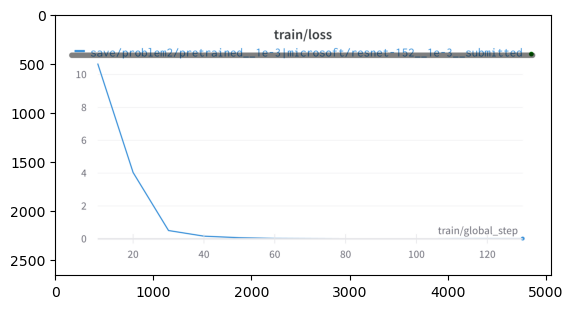

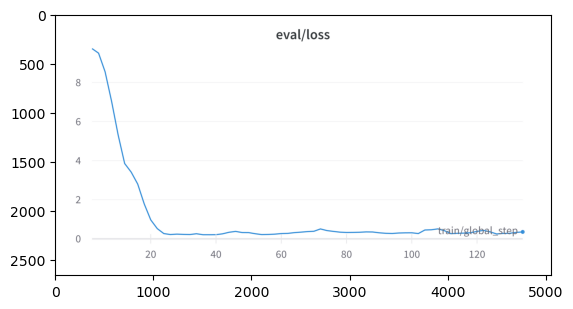

In [ ]:
plt.figure()
img = mpimg.imread("./log/problem2/setting2/setting2_train_loss.png")
plt.imshow(img)

plt.figure()
img = mpimg.imread("./log/problem2/setting2/setting2_valid_loss.png")
plt.imshow(img)

plt.figure()
img = mpimg.imread("./log/problem2/setting2/setting2_valid_acc.png")
plt.imshow(img)